# Noise2Void for Sound

In [417]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,2,3,4,5'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchaudio
import torchvision
import visdom

import numpy as np
import math
import matplotlib.pyplot as plt

import cv2
import glob
import random

from src import unet_1d
from src.utils.progressbar import progressbar

import IPython.display

# 学習に使うサウンドデータ

In [522]:
audiofile = './data/43806.wav'
audio, fs = torchaudio.load_wav(audiofile)
t = np.linspace(0,audio.shape[1]/fs,audio.shape[1])
audio_nom = audio/audio.pow(2).mean().sqrt()
IPython.display.Audio(audiofile)

In [523]:
audio.shape

torch.Size([2, 222002])

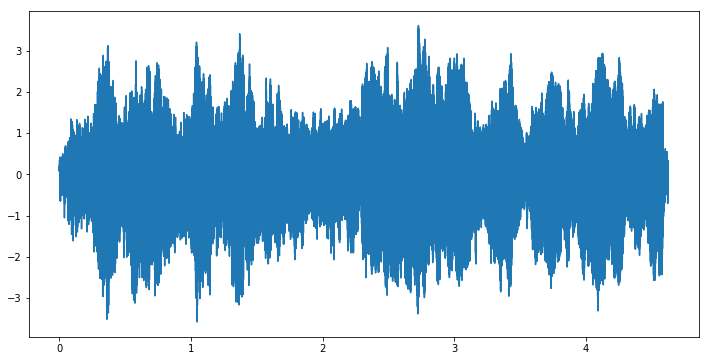

In [524]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.plot(t,audio_nom[0])
fig.show()

## dataset classの定義

もとのデータに各種ノイズを加える。   
場合により、高周波の定常信号を加える。   

In [421]:
# datasetを作る
class SoundNoise2VoidDataset(Dataset):
    def __init__(self, 
                 soundfile, 
                 mini_batch_size=1000, 
                 crop_size=44100, 
                 noise_type='gauss', 
                 noise_opt=None, 
                 add_signal=None,
                 transform=None, 
                 valid=False, 
                 sequential_crop=False):
        '''
        Args:
        soundfile: sound file path. e.g. ./path/to/wavefile.wav
        mini_batch_size: the number of random cropped sound data.
        crop_size: the length of cropped audio.
        noise_type: Noise type to be added. Gauss noize, Random impulse signal, periodic impulse signal.  ['gauss', 'random_impulse', 'periodic_impulse']
        noise_opt: Hyper parameters of class internal function:_add_noise(). e.g std when noise_type is 'gauss'
        add_signal: Function used to add another signal to the sound file signal.
        transform: Function used for preprocessing.
        valid: If valid is True, target is the original signal which is not added noise. If False, target is a noised signal.
        
        Returns:
            Source audio, Target audio, Index of blind spot
            
            Source: Random cropped and spot-blinded audio, 
            Target: Random cropped audio
        '''
        super(SoundNoise2VoidDataset, self).__init__()
        self.audio, self.sampling_freq = torchaudio.load_wav(soundfile)
        if self.audio.shape[0] != 1:
            self.audio = self.audio.mean(dim=0).unsqueeze(0)
        if add_signal:
            self.audio = add_signal(self.audio,self.sampling_freq)
        self.normalize_value = self.audio.pow(2).mean().sqrt()
        self.audio = self.audio/self.normalize_value   #normalize. RMS=1.
        
        self.crop_size = crop_size
        self.noise_type = noise_type
        self.noise_opt = noise_opt
        self.transform = transform
        self.valid = valid
        self.sequential_crop = sequential_crop
        
        self.noised_audio = self._add_noise(self.audio, self.noise_type, self.noise_opt)
        
        self.noised_audios = [] 
        if valid:
            self.origin_audios = []
        
        if not self.sequential_crop:
            for i in range(mini_batch_size):
                if crop_size is not None:
                    cropped_noisy_audio, cropped_origin_audio = self._random_crop([self.noised_audio, self.audio])
                else:
                    cropped_noisy_audio, cropped_origin_audio = self.noised_audio, self.audio
                    
                self.noised_audios.append(cropped_noisy_audio)
                if valid:
                    self.origin_audios.append(cropped_origin_audio)
        else:
            
            if self.audio.shape[1]%self.crop_size !=0:
                iteration = self.audio.shape[1]//self.crop_size + 1
            else:
                iteration = self.audio.shape[1]//self.crop_size
                
            for i in range(iteration):
                cropped_noisy_audio, cropped_origin_audio = self._sequential_crop([self.noised_audio, self.audio], i)
                self.noised_audios.append(cropped_noisy_audio)
                if valid:
                    self.origin_audios.append(cropped_origin_audio)
                
        
    def __getitem__(self,index):
        source = self.noised_audios[index]
        source, target, blind_pos = self._mask_pixel(source)
        
        if self.valid:
            target =  self.origin_audios[index]
        
        if self.transform:
            source = self.transform(source)
            target = self.transform(target)
        
        return source, target, torch.tensor(blind_pos)
    
    def __len__(self):
        return len(self.noised_audios)
    
    def _add_noise(self, audio, noise_type, opt):
        c,N = audio.shape
        if noise_type=='gauss':
            Noise = torch.normal(0, opt, (c,N))
            
        elif noise_type=='pink_noise':
            Noise = self._synth_pinknoise(N, self.sampling_freq)
            Noise = torch.tensor([Noise], dtype=torch.float) * opt
            
        elif noise_type=='random_impulse':
            l = list(np.arange(0,N,1))
            random_impulse_index = random.sample(l,int(N*opt[0]))
            Noise = torch.zeros(c,N)
            for i in random_impulse_index:
                if np.random.randint(0,2,1) == 0:
                    Noise[0,i] = opt[1]
                else:
                    Noise[0,i] = -opt[1]
        
        elif noise_type=='periodic_impulse':
            l = list(np.arange(0,N,1))
            periodic_impulse_index = l[::opt[0]]
            Noise = torch.zeros(c,N)
            Noise[0,periodic_impulse_index] = opt[1]
        else:
            Noise = torch.zeros(c,N)
        
        noise_audio = audio + Noise
        return noise_audio
        
    def _random_crop(self, audios):
        c, N  = audios[0].shape
        assert N >= self.crop_size, 'Error: Crop size:{self.crop_size} is learger than Audio size: ({N})'
        i = np.random.randint(0, N - self.crop_size +1)
        return self._crop(audios[0], i, self.crop_size), self._crop(audios[1], i, self.crop_size) 
        
    def _crop(self, audio, i, w):
        """
        Args:
            audio (numpy array): Audio to be cropped.
            i (int): Starting index to crop i.e coordinates of the left index.
            w (int): Length of the cropped audio.
        Returns:
            Audio: Cropped audio.
        """
        return audio[:,i:i+w]
    
    def _sequential_crop(self, audios, index):
        c, N = audios[0].shape
        
        if self.crop_size*(index+1) > N:
            return self._crop(audios[0], self.crop_size*index, N%self.crop_size), self._crop(audios[1], self.crop_size*index, N%self.crop_size)
        else:
            return self._crop(audios[0], self.crop_size*index, self.crop_size), self._crop(audios[1], self.crop_size*index, self.crop_size)
    
    def _mask_pixel(self, audio):
        '''
        a point is randomly selected and its intensity copied over to create a blind-spot.
        '''
        c, N = audio.shape
        random_select_index_i = np.random.randint(0, N) #a randomly selected point of Audio.
        blind_spot_i = np.random.randint(0, N) #a randomly selected point of Audio. It is to be a blind-spot.
        while blind_spot_i==random_select_index_i:
            blind_spot_i = np.random.randint(0, N)
            
        target = audio.clone()
        source = audio.clone()
        source[:,blind_spot_i] = 0#audio[:, random_select_index_i]# + audio[:,blind_spot_i]
        return source, target, blind_spot_i
    
    def _synth_pinknoise(self,duration, samprate=44100):
        """
        duration is samplesize.
        Generate pinknoise using Voss algorithm
        http://www.firstpr.com.au/dsp/pink-noise/
        """
        f_low = 10   # lowest frequency to keep pink (Hz)
        levels = math.ceil(np.log2(samprate/f_low))
        out = np.zeros(duration)
        x = np.random.normal(size=levels)
        for n in range(math.ceil(duration)):
            for m in range(levels):
                if n % 2**(m+1) == 0:
                    x[m] = np.random.normal()
                out[n] = np.random.normal() + np.sum(x)
        return out / max(abs(out))
    
def add_high_freq(x,fs,freq=10000):
    t =torch.linspace(0,x.shape[1]/fs,x.shape[1])
    return x+300*torch.sin(2*freq*np.pi*t)

In [422]:
def pixel_mse_loss(predictions, targets, pixel_pos):
    mask = torch.zeros(targets.shape).to(targets.device)
    for i,index in enumerate(pixel_pos):
        mask[i,:,index] = 1.
    return F.mse_loss(predictions*mask, targets*mask)

def pixel_L1_loss(predictions, targets, pixel_pos):
    mask = torch.zeros(targets.shape).to(targets.device)
    for i,index in enumerate(pixel_pos):
        mask[i,:,index] = 1.
    return F.l1_loss(predictions*mask, targets*mask)

In [423]:
def save_model_parameters(model,savedir, loss, loss_min, epoch,save_per_epoch=True):
    if not os.path.exists(savedir):
        os.makedirs(savedir)      
            
    try:
        state_dict = model.module.state_dict()
    except AttributeError:
        state_dict = model.state_dict()
    
    if (epoch == 0) or (loss_min > loss):
        loss_min = loss
        torch.save(state_dict, os.path.join(savedir,'best.pth'))
    if save_per_epoch:
        torch.save(state_dict, os.path.join(savedir,'epoch{0}.pth'.format(epoch)))
    
    return loss_min
    
def visualize_losses(losses, epoch, legends, title, window_name,env_name):
    viz = visdom.Visdom(env=env_name)
    viz.line(X=[epoch],Y=[losses[-1]],opts=dict(legend=legends, title=title), win=window_name, update='append')

# 学習モデル

In [472]:
def train(filename, noise_type,noise_opt,savedir='./stored/SoundNoise2Void/'):
    #model
    model = unet_1d.UNet1D(1,1,256,depth=5,batch_norm=True,up_mode='upsample',padding=True)
    if torch.cuda.is_available():
        model = nn.DataParallel(model)
        model = model.to('cuda')
    
    #dataset
    noised_dataset = SoundNoise2VoidDataset(soundfile=filename, 
                                            mini_batch_size=10000,
                                            crop_size=128,
                                            noise_type=noise_type, 
                                            noise_opt=noise_opt)
    train_loader = DataLoader(noised_dataset, batch_size=100, shuffle=True,num_workers=2)
    valid_dataset = SoundNoise2VoidDataset(soundfile=filename, 
                                           mini_batch_size=1000,
                                           crop_size=128, 
                                           noise_type=noise_type, 
                                           noise_opt=noise_opt,
                                           valid=True)
    valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=True,num_workers=2)
    
    #TRAIN MODEL
    #mini batch training
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    #     lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)
    
    
    N_epoch = 30
    loss_history = []
    loss_min = np.inf

    prog = progressbar.progbar(N_epoch,display='notebook',clear_display=True)
    for epoch in range(N_epoch):
        loss_train = train_per_epoch(train_loader,model,optimizer,loss_function=pixel_mse_loss)
        loss_valid = valid_per_epoch(valid_loader,model,loss_function=pixel_mse_loss)
        
        #         lr_scheduler.step()
    
        loss_history.append([loss_train, loss_valid])    
        loss_min = save_model_parameters(
            model,
            savedir=savedir,
            loss=loss_valid,
            loss_min=loss_min,
            epoch=epoch,
            save_per_epoch=True)
        
        visualize_losses(
            losses=np.array(loss_history),
            epoch=epoch, 
            legends=['train', 'valid'], 
            title='SoundNoise2Noise',
            window_name='SoundNoise2Void', 
            env_name='SoundNoise2Void')
        
        prog.update(epoch)
    del prog
    
    
def train_per_epoch(train_loader, model, optimizer, loss_function):
    model.train()
    
    N_batch = len(train_loader)
    running_loss = []
    prob_tr = progressbar.progbar(N_batch,display='notebook',clear_display=False)
    for batch_idx,(sources,targets,pixel_pos) in enumerate(train_loader):
        if torch.cuda.is_available():
            sources,targets = sources.to('cuda'), targets.to('cuda')
            
        predicts = model(sources)
        loss = loss_function(predicts, targets,pixel_pos)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        
        if (batch_idx%100 == 0) or (batch_idx==0) or (batch_idx==N_batch-1):
            prob_tr.update(
                batch_idx,
                info='train batch:{0}/{1}, loss:{2}'.format(batch_idx,N_batch,loss.item()))
    del prob_tr
    return np.mean(running_loss)    
    
def valid_per_epoch(valid_loader, model, loss_function):
    model.eval()
    
    running_loss = []
    prob_vl = progressbar.progbar(len(valid_loader), display='notebook', clear_display=False)
    with torch.no_grad():
        for batch_idx, (sources, targets, pixel_pos) in enumerate(valid_loader):
            if torch.cuda.is_available():
                sources, targets = sources.to('cuda'), targets.to('cuda')
            
            predicts = model(sources)
            loss = loss_function(predicts, targets, pixel_pos)
            
            running_loss.append(loss.item())
            if (batch_idx%100 == 0) or (batch_idx==0) or (batch_idx==len(valid_loader)-1):
                prob_vl.update(
                    batch_idx,
                    info='train batch:{0}/{1}, loss:{2}'.format(batch_idx,len(valid_loader),loss.item()))
    del prob_vl
    return np.mean(running_loss)    

In [525]:
train(filename='./data/43806.wav',noise_type='gauss',noise_opt=1,savedir='./stored/SoundNoise2Void/')

'    100% |################################| 0day  0:00:00 Total time: 0day  0:24:16'

In [526]:
model = unet_1d.UNet1D(1,1,256,depth=5,batch_norm=True,up_mode='upsample',padding=True)
if torch.cuda.is_available():
    model = model.to('cuda')
model.load_state_dict(torch.load('./stored/SoundNoise2Void/epoch29.pth'))
model.eval()

UNet1D(
  (conv1d): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [527]:
eval_dataset = SoundNoise2VoidDataset(soundfile='./data/43806.wav', 
                                      mini_batch_size=100,
                                      crop_size=256, 
                                      noise_type='gauss',
                                      noise_opt=1, valid=True,sequential_crop=True)

In [528]:
def reconstract(model,eval_dataset):
    source_sig = np.array([])
    origin_sig = np.array([])
    prediction_sig = np.array([])
    for i,(source, origin, idx) in enumerate(eval_dataset):
#         print(source.shape)
        source_sig = np.r_[source_sig, source.squeeze().numpy()]
        origin_sig = np.r_[origin_sig, origin.squeeze().numpy()]
        with torch.no_grad():
            predict  = model(source.unsqueeze(0).to('cuda')).to('cpu').squeeze()
#             print(predict.shape)
        prediction_sig = np.r_[prediction_sig, predict]
        
    return source_sig, origin_sig, prediction_sig

In [529]:
source, origin , prediction = reconstract(model, eval_dataset)

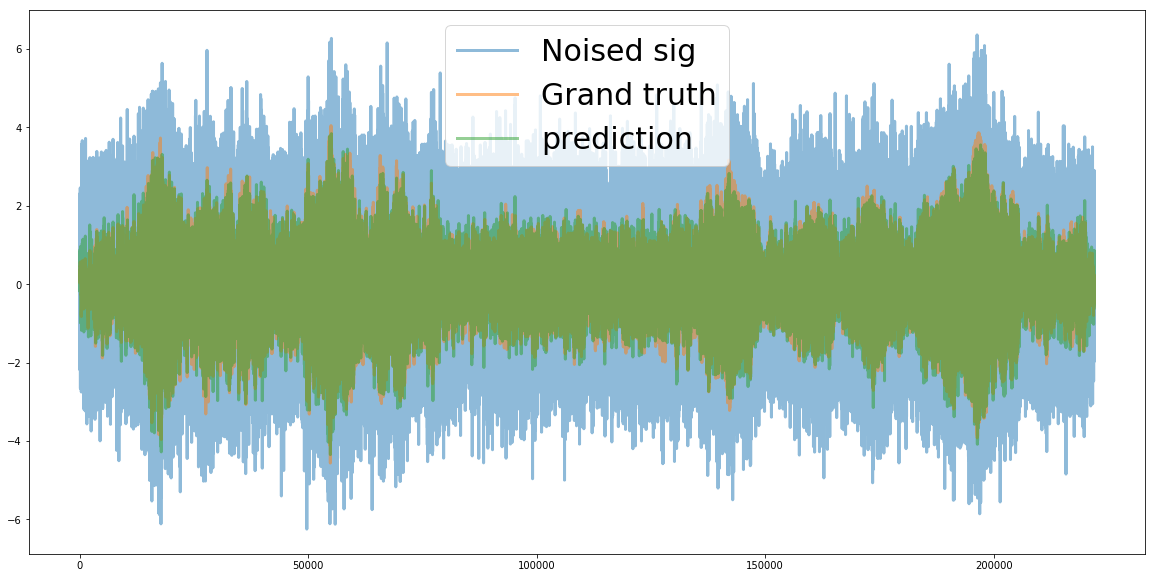

In [530]:
plt.figure(figsize=[20,10])
plt.subplot(1,1,1)
plt.plot(source,linewidth=3,linestyle='-',label='Noised sig',alpha=0.5)
plt.plot(origin,linewidth=3,linestyle='-',label='Grand truth',alpha=0.5)
plt.plot(prediction,linewidth=3,linestyle='-',label='prediction',alpha=0.5)
plt.legend(fontsize=30)
plt.show()

In [531]:
import librosa
import librosa.display
import scipy.fftpack

In [532]:
def fft(x):
    N = len(x)    # FFTのサンプル数
    X = scipy.fftpack.fft(x)*(2./N)
    freqList = np.fft.fftfreq(N, d=1.0/44100)
    return freqList[:int(N/2)], X[:int(N/2)]

In [533]:
source_flist, source_fftval = fft(source)
target_flist, target_fftval = fft(origin)
predict_flist, predict_fftval = fft(prediction)

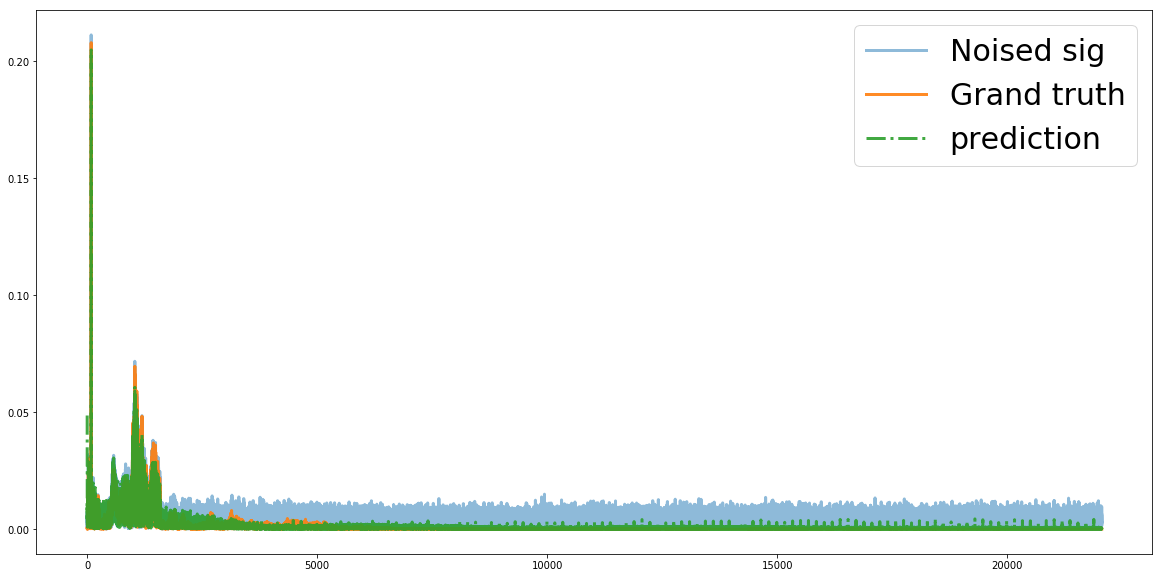

In [534]:
plt.figure(figsize=[20,10])
plt.subplot(1,1,1)
plt.plot(source_flist,np.abs(source_fftval),linewidth=3,linestyle='-',label='Noised sig',alpha=0.5)
plt.plot(target_flist,np.abs(target_fftval),linewidth=3,linestyle='-',label='Grand truth',alpha=0.9)
plt.plot(predict_flist,np.abs(predict_fftval),linewidth=3,linestyle='-.',label='prediction',alpha=0.9)
plt.legend(fontsize=30)
plt.show()

In [535]:
def display_stft(data,ax):
    spec = librosa.core.stft(y=data,n_fft=2048, hop_length=512, win_length=1024,window='hann')
    x_coords = np.linspace(0,len(data)/44100,np.abs(spec).shape[1])
    librosa.display.specshow(data=librosa.amplitude_to_db(np.abs(spec)**2,ref=np.max),x_coords=x_coords,y_axis='hz',sr=44100,ax=ax)

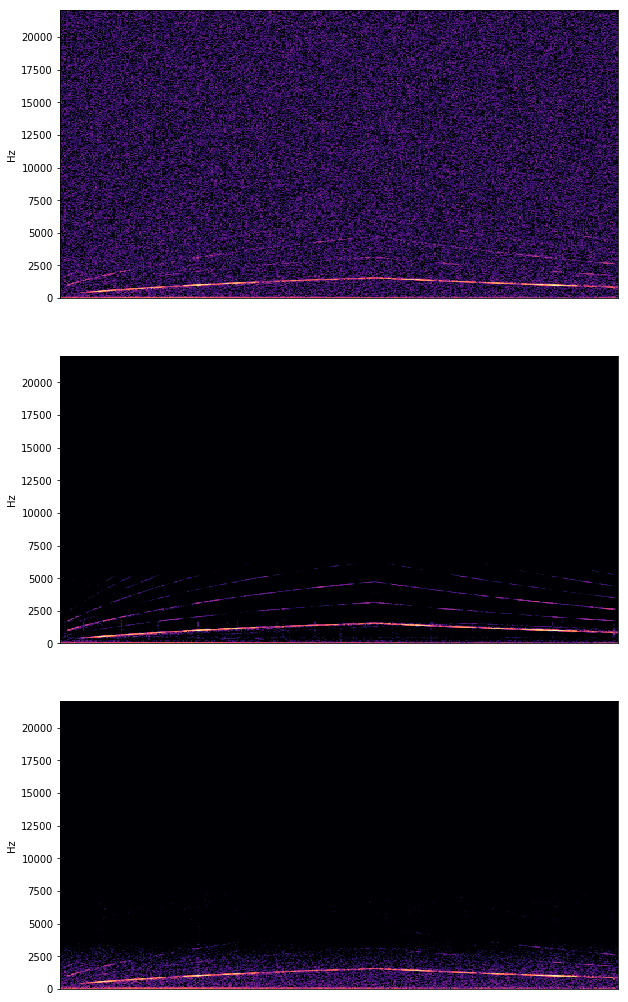

In [536]:
fig =plt.figure(figsize=[10,18])
ax1 = fig.add_subplot(311)
display_stft(source,ax1)
ax2 = fig.add_subplot(312)
display_stft(origin,ax2)
ax3 = fig.add_subplot(313)
display_stft(prediction,ax3)

In [539]:
import soundfile as sf
sf.write("source_43806.wav", source,  44100, subtype='PCM_24')
sf.write("origin_43806.wav", origin, 44100, subtype='PCM_24')
sf.write("prediction_43806.wav", prediction, 44100, subtype='PCM_24')

In [540]:
originlevel/noizelevel

1.0349156056267104

In [541]:
IPython.display.Audio('./prediction_43806.wav')

In [542]:
IPython.display.Audio('./source_43806.wav')

In [543]:
IPython.display.Audio('./origin_43806.wav')

In [456]:
predictnoiselevel = np.sqrt(np.square(prediction[:-64]-source[:-67]).mean())
signallevel = np.sqrt(np.square(source).mean())
predictionlevel = np.sqrt(np.square(prediction).mean())
noizelevel = np.sqrt(np.square(np.random.normal(0,1,100)).mean())
originlevel = np.sqrt(np.square(origin).mean())

In [544]:
20*np.log10(originlevel/noizelevel)

0.29809871556857737

In [550]:
20*np.log10(originlevel/(originlevel-predictionlevel))

16.163958342117184